```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import pyopencl
import subprocess
import os
import StringIO

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
from SWESimulators import FBL, CTCS, LxF, FORCE, HLL, HLL2, KP07, WAF, CDKLM16, DataOutput, PlotHelper

In [2]:
#Make sure we get compiler output from OpenCL
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

#Set which CL device to use, and disable kernel caching
os.environ["PYOPENCL_CTX"] = "1"
os.environ["CUDA_CACHE_DISABLE"] = "1"
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
os.environ["PYOPENCL_NO_CACHE"] = "1"

#Create OpenCL context
cl_ctx = pyopencl.create_some_context()
print "Using ", cl_ctx.devices[0].name

Using  GeForce 840M


In [3]:
def gen_test_data(nx, num_ghost_cells):
    ny = 1
    width = 100.0
    dx = width / float(nx)
    dy = 1.0

    h = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);

    #Create a gaussian "dam break" that will not form shocks
    x_center = dx*nx/2.0
    size = width / 5.0
    for j in range(-num_ghost_cells, ny+num_ghost_cells):
        for i in range(-num_ghost_cells, nx+num_ghost_cells):
            x = dx*(i+0.5) - x_center
            
            h[j+num_ghost_cells, i+num_ghost_cells] = 0.5 + 0.1*np.exp(-(x**2/size))
            #hu[j+num_ghost_cells, i+num_ghost_cells] = 0.01*np.sin(x)*np.exp(-(x**2/size))
            hu[j+num_ghost_cells, i+num_ghost_cells] = 0.1*np.exp(-(x**2/size))
    
    return h, hu, hv, dx, dy, nx, ny

In [4]:
def gen_reference():
    highres_nx = 4096;
    csv_highres = "kp07_smooth_nx=" + str(highres_nx) + ".csv"

    #If we do not have the high-res data, generate it    
    if (not os.path.isfile(csv_highres)):
        print "Generating new high-res reference!"
        ghost_cells = 2

        h0, hu0, hv0, dx, dy, sim_nx, sim_ny = gen_test_data(highres_nx, ghost_cells)

        courant_number = 0.9
        g = 9.81
        max_u = 1.0; #Estimate of maximum velocity
        dt = courant_number * dx / (max_u + np.sqrt(g*1.2))

        #Initialize reference simulator
        sim = KP07.KP07(cl_ctx,
                        h0, hu0, hv0, \
                        sim_nx, sim_ny, \
                        dx, dy, dt, \
                        g)


        t = sim.step(5.0)
        h1, hu1, hv1 = sim.download()

        x = np.linspace(0.5*dx, (highres_nx-0.5)*dx, highres_nx)
        h = h1[ghost_cells, ghost_cells:-ghost_cells]
        hu = hu1[ghost_cells, ghost_cells:-ghost_cells]

        #h_init = h0[ghost_cells, ghost_cells:-ghost_cells]
        #plt.plot(x, h_init, '--')
        #plt.plot(x, h_init[::-1], ':')
        #plt.plot(x, h, '-')
        #plt.plot(x, h[::-1], 'x')
        #plt.show()
        
        highres_solution = np.vstack((x, h, hu)).T
        np.savetxt(csv_highres, highres_solution, delimiter=',', header='x, h, hu')
    
    #Read the solution
    return np.genfromtxt(csv_highres, comments='#', delimiter=',', skip_header=1, usecols=(0, 1, 2))

In [5]:
def downsample(highres_solution, nx):
    #"Downsample" to requested number of points
    #Since our solution is a set of piecewise constant functions, we must integrate this function over our 
    #desired output mesh
    highres_nx = highres_solution.shape[0]
    scaling_factor = highres_nx / float(nx)
            
    reference = np.zeros((nx, 1))
        
    """ 
    Computes the integral of highres as a piecewise constant function over the area
    [i*scaling_factor, (i+1)*scaling_factor]
    """
    def integrate(highres, i, scaling_factor):
        # This operation can be viewed as a convolution
        # First generate our convolution kernel
        first = np.floor(i*scaling_factor)
        last = np.ceil((i+1)*scaling_factor)
        
        num_elements = last - first
        kernel = np.ones(num_elements);
        
        # Calculate weight of element
        kernel[0] = 1.0 - np.mod(i*scaling_factor, 1)
        
        # Calculate weight of last element
        kernel[-1] = 1.0 - (last - (i+1)*scaling_factor)
        
        # Normalize the kernel
        kernel = kernel / scaling_factor
                
        # Convolve with the correct elements
        integral = np.sum(highres[first:last] * kernel)
        
        #print i, first, last, kernel.shape#, kernel[:2], kernel[-2:], integral
        #print kernel, integral
        
        
        return integral
        
    for i in range(nx):
        begin = np.floor(i*scaling_factor)
        end = np.ceil(i*scaling_factor)
        #t = i*scaling_factor - begin
        #reference[i, :] = (1.0-t)*highres_solution[begin,:] + t*highres_solution[end,:]
        
        reference[i] = integrate(highres_solution, i, scaling_factor)
    
    return reference

Generating new high-res reference!


C:\Users\anbro\AppData\Local\Enthought\Canopy32\User\lib\site-packages\ipykernel\__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


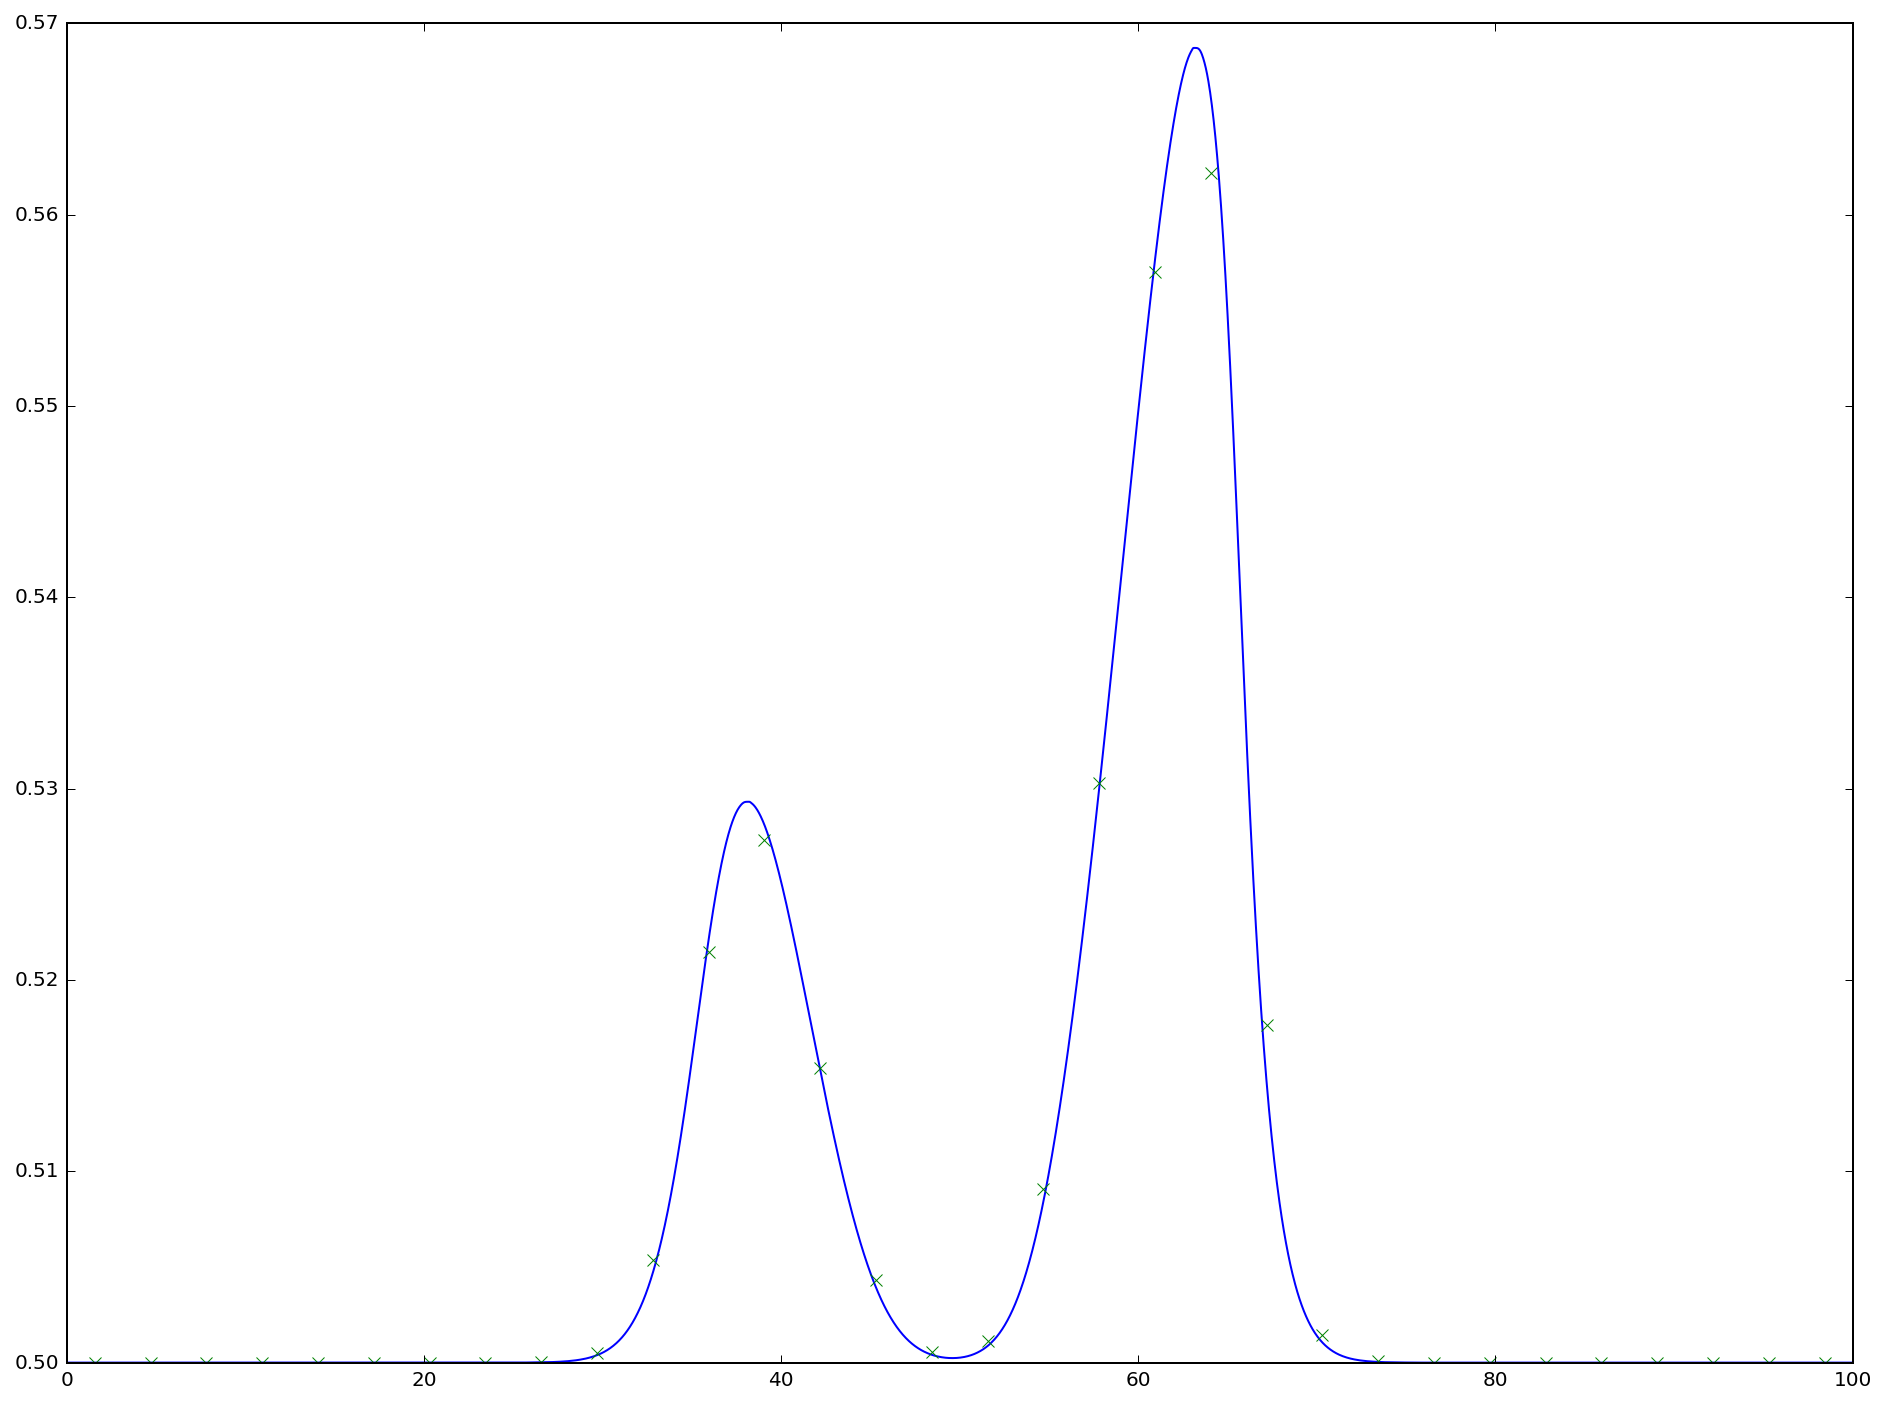

In [6]:
reference = gen_reference()

rx = downsample(reference[:,0], 32)
rh = downsample(reference[:,1], 32)

plt.plot(reference[:,0], reference[:,1], '-')
plt.plot(rx, rh, 'x')

plt.show()

In [7]:
def run_benchmark(simulator, nx, g, dt, ghost_cells):
    
    h0, hu0, hv0, dx, dy, nx, ny = gen_test_data(nx, ghost_cells)

    #Initialize simulator
    sim = simulator(cl_ctx,
                    h0, hu0, hv0, \
                    nx, ny, \
                    dx, dy, dt, \
                    g)

    t = sim.step(5.0)
    h1, hu1, hv1 = sim.download()

    reference = gen_reference()
    x = downsample(reference[:,0], 32)
    h_ref = downsample(reference[:,1], 32)
    hu_ref = downsample(reference[:,1]*reference[:,2], 32)
    
    h = downsample(h1[ghost_cells, ghost_cells:-ghost_cells], 32)
    hu = downsample(hu1[ghost_cells, ghost_cells:-ghost_cells], 32)
    
    error = np.linalg.norm(np.abs(h_ref - h), ord=2)
    conservation = (np.sum(h_ref) - np.sum(h))*dx
    
    return x, h_ref, hu_ref, h, hu, error, conservation

In [8]:
def compute_convergence(simulator, ghost_cells, domain_sizes, plot=False):
    l2_error = np.zeros(len(domain_sizes))
    conservation = np.zeros(len(domain_sizes))
    
    g = 9.81
    max_u = 0.02; #Estimate of maximum velocity
    courant_number = 0.45
    dt = courant_number * (10.0 / float(max(domain_sizes))) / (max_u + np.sqrt(g*0.5))

    for i, nx in enumerate(domain_sizes):
        x, h_ref, hu_ref, h, hu, err, cons = run_benchmark(simulator, nx, g, dt, ghost_cells)

        l2_error[i] = err
        conservation[i] = cons

        if (plot):
            plt.plot(x, h_ref)
            plt.plot(x, h, label=['nx=', str(nx)])
                        
    return conservation, l2_error

In [9]:
domain_sizes = [32, 64, 128, 256, 512, 1024]
simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, WAF.WAF, KP07.KP07]
simulator_ghost_cells = [1, 1, 1, 2, 2, 2]
simulator_names = ['LxF', 'FORCE', 'HLL', 'HLL2', 'WAF', 'KP07']

In [10]:
conservation = np.zeros((len(simulators), len(domain_sizes)))
l2_error = np.zeros((len(simulators), len(domain_sizes)))

for i in range(len(simulators)):
    print simulator_names[i]
    cons, err = compute_convergence(simulators[i], simulator_ghost_cells[i], domain_sizes)
    conservation[i,:] = cons
    l2_error[i,:] = err

LxF


C:\Users\anbro\AppData\Local\Enthought\Canopy32\User\lib\site-packages\ipykernel\__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


FORCE
HLL
HLL2
WAF
KP07


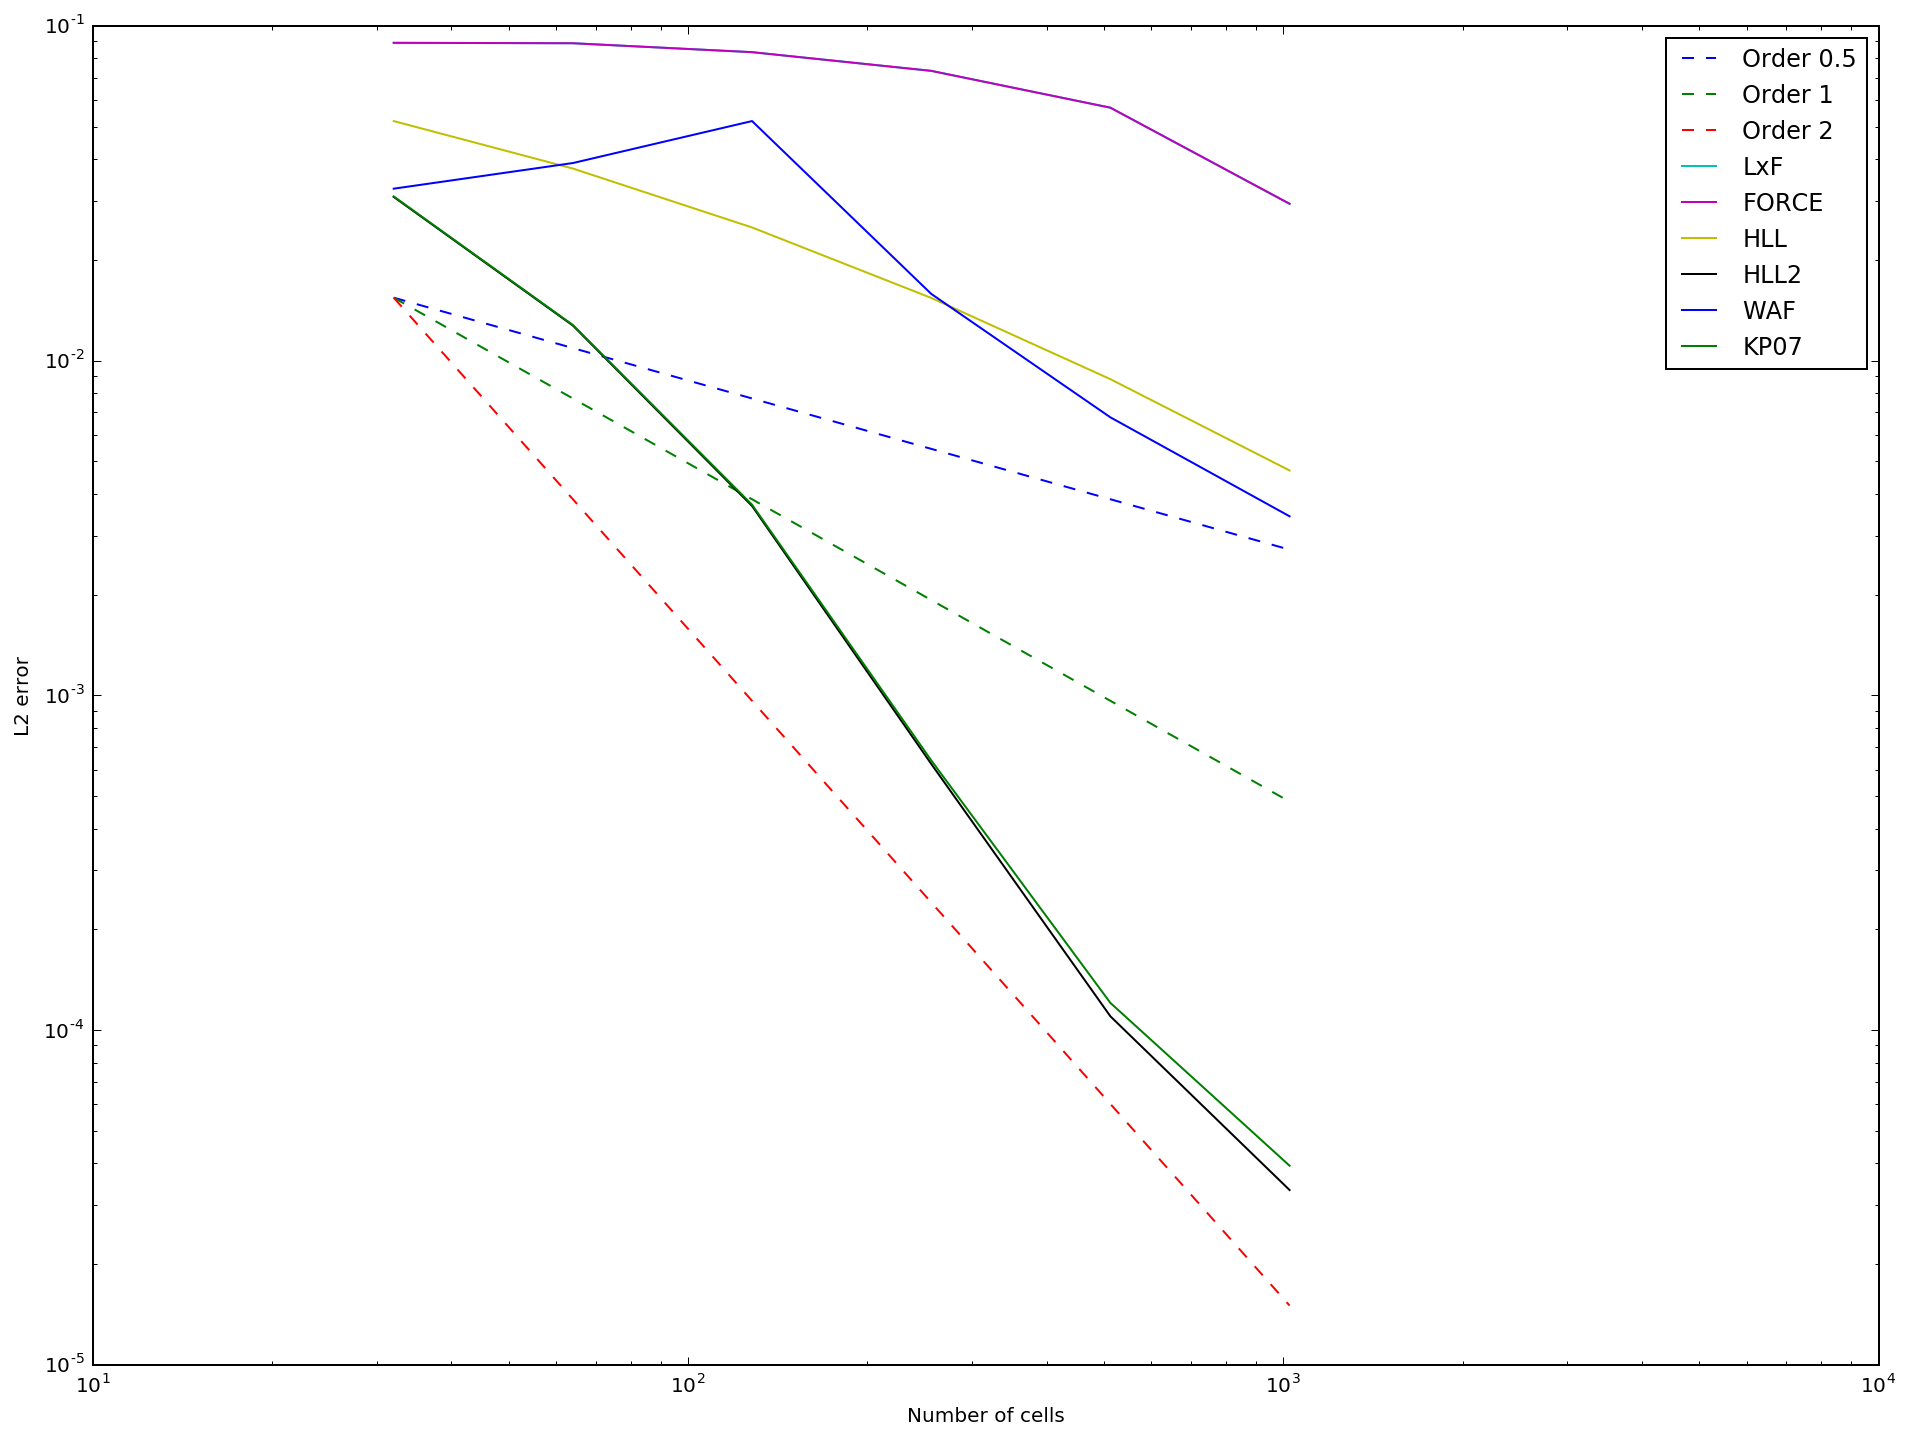

In [11]:
plt.figure()
x = np.linspace(domain_sizes[0], domain_sizes[-1], 100);

scaling = np.min(l2_error[:,0]) * domain_sizes[0]**0.5 * 0.5
plt.loglog(x, scaling/(np.sqrt(x)), '--', label='Order 0.5')

scaling = np.min(l2_error[:,0]) * domain_sizes[0] * 0.5
plt.loglog(x, scaling/x, '--', label='Order 1')

scaling = np.min(l2_error[:,0]) * domain_sizes[0]**2 * 0.5
plt.loglog(x, scaling/(x*x), '--', label='Order 2')

for i in range(len(simulators)):
    plt.loglog(domain_sizes, l2_error[i,:], label=simulator_names[i])
    
plt.xlabel('Number of cells')
plt.ylabel('L2 error')
plt.legend()